# COMS W4995 Deep Learning Project
Kai Zhou kz2329@columbia.edu Kathleen He kh3030@columbia.edu Yuechen Yang yy2608@columbia.edu

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import Formatter
import datetime as dt
import pandas as pd

from importlib import reload
from time import time
import os.path

## Load Utilities

In [2]:
from utils.evaluator import Evaluator
from utils.formatter import DateFormatter

evaluator = Evaluator()

## Load Environment

In [3]:
from stable_baselines.common.vec_env import DummyVecEnv
from envs import equity_env

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
reload(equity_env)

env = equity_env.EquityEnv(split_data=True)
env = DummyVecEnv([lambda: env])

-- Data Loaded --
-- Environment Created --


## Initialize Models 

In [5]:
from stable_baselines.common.policies import MlpPolicy, MlpLstmPolicy
from stable_baselines.ppo2 import PPO2
from stable_baselines import A2C
from stable_baselines import ACKTR

from stable_baselines import bench, logger
from stable_baselines.results_plotter import load_results, ts2xy

### PPO2

In [6]:
model_ppo2 = PPO2(MlpLstmPolicy, env, n_steps=240, learning_rate=0.0005, verbose=0, nminibatches=1, 
             policy_kwargs={"n_lstm":36, "layers":[36,36]})





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.




/usr/local/lib/python3.5/dist-packages/stable_baselines/common/policies.py:415: UserWarning: The layers parameter is deprecated. Use the net_arch parameter instead.
  warnings.warn("The layers parameter is deprecated. Use the net_arch parameter instead.")




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





### A2C

In [7]:
model_a2c = A2C(MlpLstmPolicy, env, verbose=0,
                  n_steps=240, learning_rate=0.0005,
                  policy_kwargs={"n_lstm":36, "layers":[36,36]}               
               )

/usr/local/lib/python3.5/dist-packages/stable_baselines/common/policies.py:415: UserWarning: The layers parameter is deprecated. Use the net_arch parameter instead.
  warnings.warn("The layers parameter is deprecated. Use the net_arch parameter instead.")





Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### ACKTR

In [8]:
model_acktr = ACKTR(MlpLstmPolicy, env, verbose=0, 
                  n_steps=240, learning_rate=0.0005,
                  policy_kwargs={"n_lstm":36, "layers":[36,36]})                    


/usr/local/lib/python3.5/dist-packages/stable_baselines/common/policies.py:415: UserWarning: The layers parameter is deprecated. Use the net_arch parameter instead.
  warnings.warn("The layers parameter is deprecated. Use the net_arch parameter instead.")


## Train Models

In [9]:
start = time()

total_timesteps = 120*2000

model_ppo2.learn(total_timesteps=total_timesteps)
model_a2c.learn(total_timesteps=total_timesteps)
model_acktr.learn(total_timesteps=total_timesteps)

end = time()
t = end - start
print("Takes %d s to run" % t)







Takes 1943 s to run


## Create full sample test result

In [10]:
test_env = equity_env.EquityEnv(split_data=False, test_option="full")
test_env = DummyVecEnv([lambda: test_env])

-- Data Loaded --
-- Environment Created --


In [11]:
start = time()

pnl_ppo2, date_ppo2, trans_cost_ppo2, actions_ppo2 = evaluator.evaluate(model_ppo2, test_env)
pnl_a2c, dates_a2c, trans_cost_a2c, actions_a2c = evaluator.evaluate(model_a2c, test_env)
pnl_acktr, dates_acktr, trans_cost_acktr, actions_acktr = evaluator.evaluate(model_acktr, test_env)

end = time()
t = end - start
print("Takes %d s to run" % t)

Takes 214 s to run


In [12]:
evaluator.print_statistics("PPO2", pnl_ppo2, actions_ppo2)

PPO2 Annual Sharpe: 3.446032223811212
PPO2 Annual Return: 0.6135171914185863
PPO2 Annual Volatility: 0.009012519787547767
PPO2 Annual Turnover: 60636.346570185495
PPO2 Maximum Drawdown: 0.6433011889457703


In [13]:
evaluator.print_statistics("A2C", pnl_a2c, actions_a2c)

A2C Annual Sharpe: 16.13345779738698
A2C Annual Return: 0.31557145067509673
A2C Annual Volatility: 0.0009903866686625064
A2C Annual Turnover: 13751.797122498956
A2C Maximum Drawdown: 0.0913449302315712


In [14]:
evaluator.print_statistics("ACKTR", pnl_acktr, actions_acktr)

ACKTR Annual Sharpe: -0.5026264194782523
ACKTR Annual Return: -0.019268540321411218
ACKTR Annual Volatility: 0.00194176142626316
ACKTR Annual Turnover: 12212.543496313569
ACKTR Maximum Drawdown: 1.4338929653167725


## Construct Baseline Strategies

In [15]:
prices = pd.read_csv("data/price.csv", parse_dates=[0])
dates = prices.iloc[:,0].apply(lambda x: pd.to_datetime(x))
principal = 1000000

### 1. Momentum Strategy

In [16]:
# First, need to get return. need to define a look back period
def momentum_signal(price_data, look_back, normalize=True):
    price_data = prices.iloc[:, [2,4,6]].values
    delay_price = np.roll(price_data, look_back, axis=0)
    delay_price[:look_back] = np.nan
    mom_sig = (price_data - delay_price) / delay_price
    if normalize:
        mom_sig = mom_sig - mom_sig.mean(axis=1,keepdims=True)
        mom_sig = mom_sig / ((mom_sig > 0) * mom_sig).sum(axis=1, keepdims=True)
    return mom_sig

ret1 = momentum_signal(prices, 1, False)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


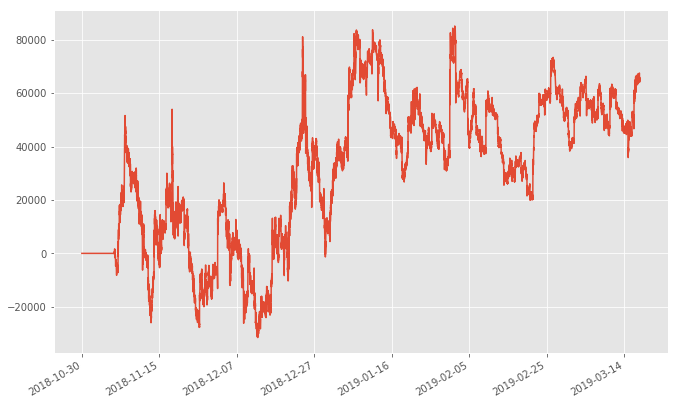

0.6869607785215986


In [17]:
mom = momentum_signal(prices, 2100)

pnl_mom = np.sum(mom * np.roll(ret1, -1, axis=0), axis=1) * principal
pnl_mom = np.nan_to_num(pnl_mom)

plt.style.use("ggplot")
formatter = DateFormatter(dates)
fig, ax = plt.subplots(figsize=(11, 7))
ax.xaxis.set_major_formatter(formatter)
ax.plot(np.arange(pnl_mom.shape[0]), np.cumsum(pnl_mom))
fig.autofmt_xdate()
plt.show()

print(evaluator.annual_sharpe(pnl_mom))

### 2. Buy-and-hold Strategy

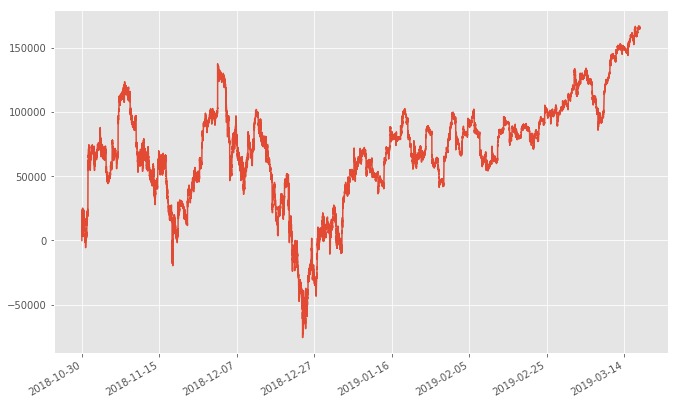

1.4030214749563588


In [18]:
mut = ret1+1
mut[0] = 1
pnl_hold = np.sum((np.cumprod(mut, axis=0)-1) / 3 * principal, axis=1)
pnl_hold = pnl_hold - np.roll(pnl_hold, 1)
pnl_hold[0] = 0
plt.style.use("ggplot")
formatter = DateFormatter(dates)
fig, ax = plt.subplots(figsize=(11, 7))
ax.xaxis.set_major_formatter(formatter)
ax.plot(np.arange(pnl_hold.shape[0]), np.cumsum(pnl_hold))
fig.autofmt_xdate()
plt.show()

print(evaluator.annual_sharpe(pnl_hold))

### 3. Compare RL with the baseline strategies

In [19]:
import pickle

In [20]:
# with open("outputs/model_pnl_35000.dms", "rb") as f:
#     pnl_ppo = pickle.load(f)

In [23]:
pnl_ppo = pnl_ppo2
n = pnl_ppo.shape[0]
pnl_mom = pnl_mom[:n]
pnl_hold = pnl_hold[:n]

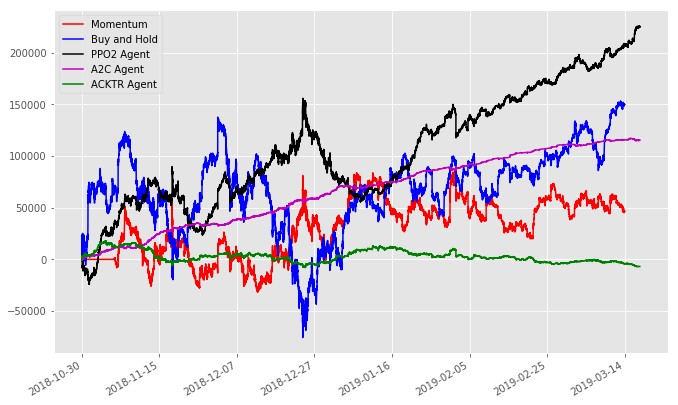

In [24]:
plt.style.use("ggplot")
formatter = DateFormatter(dates)
fig, ax = plt.subplots(figsize=(11, 7))
ax.xaxis.set_major_formatter(formatter)
ax.plot(np.arange(pnl_mom.shape[0]), np.cumsum(pnl_mom), c="r", label="Momentum")
ax.plot(np.arange(pnl_hold.shape[0]), np.cumsum(pnl_hold), c="b", label="Buy and Hold")
# ax.plot(np.arange(pnl_ppo.shape[0]), np.cumsum(pnl_ppo), c="k", label="PPO Agent")
ax.plot(np.arange(pnl_ppo2.shape[0]), np.cumsum(pnl_ppo2), c="k", label="PPO2 Agent")
ax.plot(np.arange(pnl_a2c.shape[0]), np.cumsum(pnl_a2c), c="m", label="A2C Agent")
ax.plot(np.arange(pnl_acktr.shape[0]), np.cumsum(pnl_acktr), c="g", label="ACKTR Agent")

fig.autofmt_xdate()
plt.legend()
plt.show()